# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [2]:
import gc
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

Проверяем окружение, создаем необходимые каталоги и файлы

In [2]:
%%time
!scripts/download_data.sh

All files are already downloaded, if you need to forcely download them, please, use the -f or --force option


CPU times: user 7.73 ms, sys: 3.93 ms, total: 11.7 ms
Wall time: 116 ms


In [3]:
input_data_path = Path('ym')
output_data_path = Path('data')
output_data_path.mkdir(exist_ok=True)
output_recommendations_path = Path('recommendations')
output_recommendations_path.mkdir(exist_ok=True)

assert input_data_path.exists()
assert input_data_path.is_dir()
assert set(file.stem for file in input_data_path.glob('*.parquet')) == {"catalog_names", "interactions", "tracks"} 

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

Cтруктура данных:

 * `interactions`:
    - `user_id` — идентификатор пользователя
    - `track_id` — идентификатор музыкального трека
    - `track_seq` — номер места трека в истории пользователя
    - `started_at` — дата начала прослушивания трека

 * `tracks`:
    - `track_id` — идентификатор музыкального трека
    - `albums` —  список идентификаторов альбомов, содержащих трек
    - `artists` — список идентификаторов исполнителей трека
    - `genres` — список идентификаторов жанров, к которым принадлежит трек

 * `catalog_names`:
    - `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра)
    - `type` — тип идентификатора
    - `name` — имя (название) каталожной единицы

In [4]:
tracks = pd.read_parquet(input_data_path / "tracks.parquet")
catalog_names = pd.read_parquet(input_data_path / "catalog_names.parquet")
interactions = pd.read_parquet(input_data_path / "interactions.parquet")

In [5]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [6]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [7]:
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

## Количество строк

In [8]:
print(f"Кол-во строк в датасете с треками: {len(tracks):e}")

Кол-во строк в датасете с треками: 1.000000e+06


In [9]:
print(f"Кол-во строк в датасете с каталогом: {len(catalog_names):e}")

Кол-во строк в датасете с каталогом: 1.812471e+06


In [10]:
print(f"Кол-во строк в датасете со взаимодействиями: {len(interactions):e}")

Кол-во строк в датасете со взаимодействиями: 2.226299e+08


## Типы данныx

In [11]:
tracks.dtypes

track_id     int64
albums      object
artists     object
genres      object
dtype: object

In [12]:
catalog_names.dtypes

id       int64
type    object
name    object
dtype: object

In [13]:
interactions.dtypes

user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

## Пропущенные значения

In [14]:
tracks.isna().sum()

track_id    0
albums      0
artists     0
genres      0
dtype: int64

In [15]:
catalog_names.isna().sum()

id      0
type    0
name    0
dtype: int64

In [16]:
interactions.isna().sum()

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

## Пустые списки и пустые строки

Пустые списки исполнителей, альбомов и жанров

In [17]:
empty_albums = tracks.albums.str.len() == 0
empty_artists = tracks.artists.str.len() == 0
empty_tracks = tracks.genres.str.len() == 0
empty_name = catalog_names.name.str.len() == 0
empty_type = catalog_names.type.str.len() == 0
print(
f"""
Пустые списки альбомов: {empty_albums.sum() / len(empty_albums) * 100.:.2}%
Пустые списки исполнителей: {empty_artists.sum() / len(empty_artists) * 100.:.2}%
Пустые списки жанров: {empty_tracks.sum() / len(empty_tracks) * 100.:.2}%
Общее количество пустых ячеек в треках: {(empty_albums + empty_artists + empty_tracks).sum() / len(empty_tracks) * 100.:.2}%
Трэки, у которых что-то из вышеперечисленного пустое: {(empty_albums | empty_tracks | empty_artists).sum() / len(empty_tracks) * 100.:.2}%
Пустые имена в каталоге: {empty_name.sum()}
Пустые жанры в каталоге: {empty_type.sum()}
""")


Пустые списки альбомов: 0.0018%
Пустые списки исполнителей: 1.5%
Пустые списки жанров: 0.37%
Общее количество пустых ячеек в треках: 1.9%
Трэки, у которых что-то из вышеперечисленного пустое: 1.9%
Пустые имена в каталоге: 0
Пустые жанры в каталоге: 0



## Повторяющиеся значения

In [18]:
duplicated_tracks = tracks.explode("albums").explode("artists").explode("genres").duplicated().sum()
duplicated_catalog_names = catalog_names.duplicated().sum()
print(
f"""
Повторяющиеся строки в треках: {duplicated_tracks}
Повторяющиеся строки в каталоге: {duplicated_catalog_names}
""")


Повторяющиеся строки в треках: 0
Повторяющиеся строки в каталоге: 0



In [19]:
print(f"Повторяющиеся строки во взаимодействиях: {interactions.duplicated().sum()}")

Повторяющиеся строки во взаимодействиях: 0


## Проверка гипотез относительно пользовательской оценки
1. каждая строка в таблице `interactions` - это одно взаимодействие пользователя с треком, тогда у некоторых пользователей один и тот же трек может присутствовать несколько раз с разными значениями `started_at`
2. в `interactions` все треки одного пользователя уникальны, при этом `started_at` это момент начала первого (или последнего) прослушивания трека, а `track_seq` - это порядковый номер `started_at` (ранг) отсортированном списке
3. что-то другое...

In [20]:
print(
    "Количество дублирующихся треков в треклистах:",
    (interactions.groupby(['user_id', 'track_id']).count() > 1).sum(),
    sep='\n')

Количество дублирующихся треков в треклистах:
track_seq     0
started_at    0
dtype: int64


In [21]:
print(
    "Число строк для которых ранг started_at не совпадает с track_seq:",
    (interactions[["user_id", "started_at"]].groupby("user_id").rank(method="first")["started_at"] != interactions["track_seq"]).sum())

Число строк для которых ранг started_at не совпадает с track_seq: 0


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

**Проблемы с данными:**
 - данные в таблице `interactions` имеют очень большой объем, для работы нужно много оперативки
 - для 0.0018% треков отсутствуют списки альбомов
 - для 1.5% треков отсутствуют списки исполнителей
 - для 0.37% треков отсутствуют списки жанров
 - отсутствуют в явном виде пользовательские оценки
    - `track_seq` - просто ранг значений `started_at` для треков одного `user_id`
    - треки у одного `user_id` уникальны, поэтому относительно сущности `started_at` могут быть справедливы, как минимум, две гипотезы
        - `started_at` - время последнего начала прослушивания трека, которое перетерло все предыдущие (в этом случае деление по времени на тестовую и тренировочную выборки будет совершенно не возможным)
        - `started_at` - время первого взаимодействия пользователя с треком. При этом совершенно неизвестно: запускал ли вообще пользователь трек во второй, третий и тд разы
    
    Поскольку в задаче требуется отделить тестовую выборку по определенному моменту времени, мы будем считать рабочей вторую гипотезу - других оснований я не вижу
 - индексы в таблице `catalog_names` не уникальны, есть дубликаты: индексы альбомов, исполнителей и жанров образуют пересекающиеся множества

 **Корректирующие действия:**
 - понял, что слежу за оперативкой, по возможности дропая все ненужное
 - до конца не ясно, является ли отсутствие альбомов, исполнителей и жанров проблемой, решил оставить как есть
 - `track_seq` - можно смело удалить из таблицы, чтобы соптимизировать хранение, так как никакой новой информации, кроме возможности упорядочить треки, прослушанные в один день он не несет
 - вероятно, в качестве оценки нужно использовать величину `started_at`. Предположим, что треки, прослушанные в первый раз более полугода назад, начинают забываться, при этом процесс забвения имеет вид убывающей экспоненты, где период полураспада - полгода. Тогда оценки будем вычислять так:$$rating = {1 \over 2}^{{max(started\_at) - started\_at} \over {half\_year}}$$
 - при работе с `catalog_names` необходимо дополнительно фильтровать по типу, чтобы не вытащить, например, альбом вместо жанра
 - при построении матрицы взаимодействий нужно перекодировать все индексы, так как в последовательностях индексов могут быть пропуски

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

/tmp/ipykernel_13947/3878380463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_per_mounth["month"] = interactions["started_at"].dt.to_period('M')


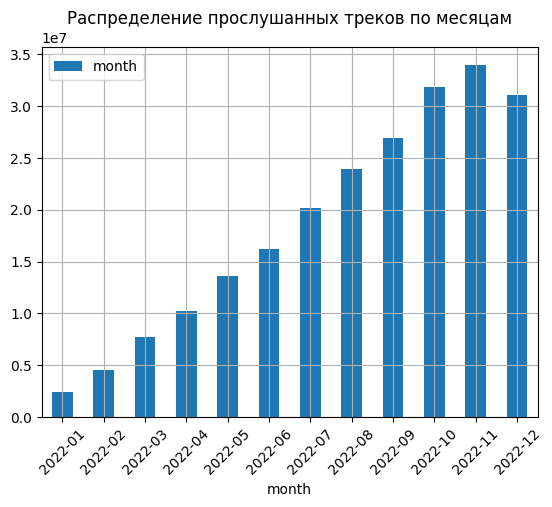

In [22]:
tracks_per_mounth = interactions[["track_id", "started_at"]]
tracks_per_mounth["month"] = interactions["started_at"].dt.to_period('M')
tracks_per_mounth = tracks_per_mounth[["month", "track_id"]].groupby("month").count().rename(columns={"track_id": "month"})
tracks_per_mounth.plot.bar()
plt.xticks(rotation=45)
plt.title("Распределение прослушанных треков по месяцам")
plt.grid(which="both")
del tracks_per_mounth

Наиболее популярные треки

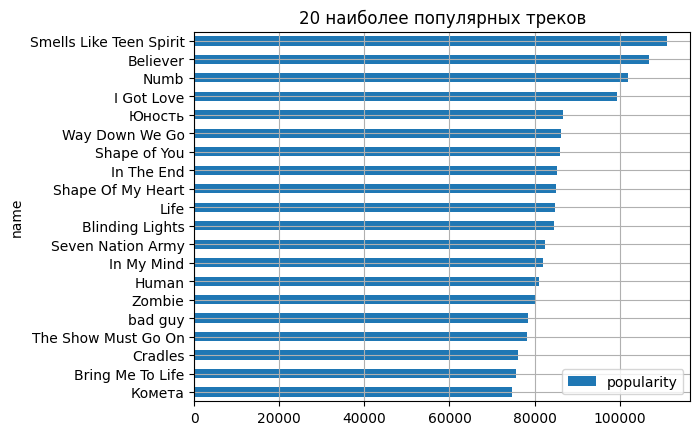

In [23]:
interactions[["track_id", "user_id"]]\
    .groupby("track_id")\
    .count()\
    .rename(columns={"user_id": "popularity"})\
    .merge(catalog_names[catalog_names["type"] == "track"][["id", "name"]], left_on="track_id", right_on="id")\
    [["name", "popularity"]].nlargest(columns=["popularity"], n=20)\
        .sort_values(by="popularity").plot.barh(x="name", y="popularity")
plt.title("20 наиболее популярных треков")
plt.grid()

Наиболее популярные жанры

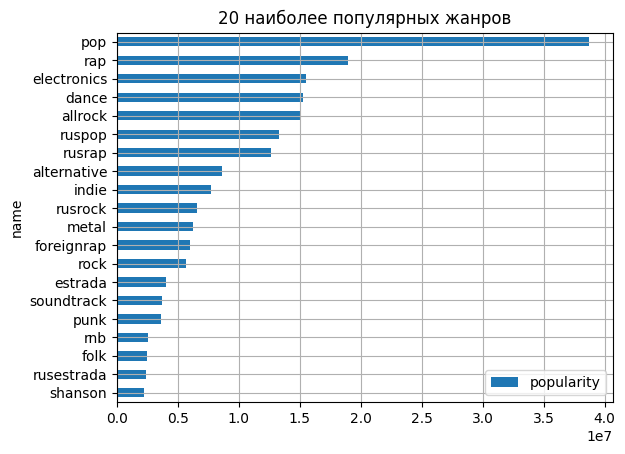

In [24]:
genres_popularity = interactions[["track_id", "user_id"]]\
    .groupby("track_id")\
    .count()\
    .merge(tracks[["track_id", "genres"]], on="track_id")\
    .rename(columns={"user_id": "track_popularity"})
genres_popularity["weight"] = genres_popularity.genres.str.len()

genres_popularity = genres_popularity\
    .explode("genres")\
    .rename(columns={"genres": "genre_id"})

genres_popularity["genre_id"] = genres_popularity["genre_id"].astype("Int64")
genres_popularity = genres_popularity.merge(catalog_names[catalog_names["type"] == "genre"], left_on="genre_id", right_on="id", how="left")
genres_popularity["popularity"] = genres_popularity["track_popularity"] / genres_popularity["weight"]
genres_popularity = genres_popularity[["name", "popularity"]].groupby("name").sum().nlargest(columns=["popularity"], n=20).sort_values(by="popularity")
genres_popularity.plot.barh(y="popularity")
plt.title("20 наиболее популярных жанров")
plt.grid()
del genres_popularity

Треки, которые никто не прослушал

In [25]:
print(
    f"Количество непрослушанных треков:",
    (~tracks["track_id"].isin(interactions.track_id)).sum())

Количество непрослушанных треков: 0


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

В качестве максимального времени просто возьмем дату по которой в задании спринта предлагается делить тренировочную и тестовую выборки `16 декабря 2022 года (не включительно)`

In [27]:
events = interactions[["user_id", "track_id", "started_at"]]
max_time = pd.to_datetime("16-12-2022", format="%d-%m-%Y")
half_year_days = 365. / 2.

events["rating"] = 1 / np.power(2, (max_time - interactions.started_at).dt.days / half_year_days)
events["rating"] = (events.rating / events.rating.max() * 255).astype(np.uint8)
items = tracks[["track_id", "genres"]]\
    .explode("genres")\
    .merge(catalog_names[catalog_names["type"] == "genre"], left_on="genres", right_on="id", how="left")\
    .rename(columns={"genres": "genre_id", "name": "genre"}).drop(columns=["id", "type"])
unknown_id = items["genre_id"].max() + 1
items.loc[items["genre"].isna(), "genre_id"] = unknown_id
items.loc[items["genre"].isna(), "genre"] = "unknown"
items.track_id = items.track_id.astype(np.uint32)
items.genre_id = items.genre_id.astype(np.uint16)
items = items.rename(columns={"track_id": "item_id"})


In [28]:
events.dtypes

user_id                int32
track_id               int32
started_at    datetime64[ns]
rating                 uint8
dtype: object

In [29]:
items.dtypes

item_id     uint32
genre_id    uint16
genre       object
dtype: object

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

Будем использовать `dvc` для версионирования данных.

`.dvc/config`:
````(toml)
[core]
    remote = my_storage
['remote "my_storage"']
    url = s3://s3-student-mle-20240919-daec520330/recsys
    endpointurl = https://storage.yandexcloud.net
````

`config.local`:
````(toml)
['remote "my_storage"']
    access_key_id = <your-access-key-id>
    secret_access_key = <your-secret-access-key>
````


In [30]:
items.to_parquet(output_data_path / "items.parquet")
events.to_parquet(output_data_path / "events.parquet")

In [31]:
!dvc add data && dvc push data

⠋ Checking graph                                       core>
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/home/mle-user/mle_projects/mle-project-sprint-4-v001/.d
                                                                                
!
  0%|          |Adding data to cache                  0/1 [00:00<?,     ?file/s]
                                                                                
!
Checking out /home/mle-user/mle_projects/mle-project-sprint-4-v001/data |0.00 [0
100% Adding...|████████████████████████████████████████|1/1 [00:02,  2.39s/file]

To track the changes with git, run:

	git add data.dvc

To enable auto staging, run:

	dvc config core.autostage true
Pushing
!
  0% Querying remote cache|                          |0/1 [00:00<?,    ?files/s]
100% Querying remote cache|█████████████████████|1/1 [00:00<00:00,  2.37f

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [ ]:
# Удалим все присутствующие в памяти датафреймы
del empty_albums,\
    empty_artists,\
    empty_name,\
    empty_tracks,\
    empty_type,\
    events,\
    items, \
    interactions, \
    catalog_names, \
    tracks

# Запустим сборщик мусора
_ = gc.collect()

# Тут можно перезапустить ядро, но можно и не перезапускать
# Если ядро было перезапущенно, то нужно:
#   1. заново импортировать библиотеки (ячейка 1)
#   2. заново пересоздать директории с данными (ячейка 3)

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [41]:
%%bash
DATA_DIR=data
if [ -f $DATA_DIR/items.parquet ] && [ -f $DATA_DIR/events.parquet ]; then
echo "Чтобы принудительно загрузить данные снова нужно удалить файлы из директории ${DATA_DIR}"
else
echo "Загрузка ..."
dvc pull data.dvc
fi

Чтобы принудительно загрузить данные снова нужно удалить файлы из директории data


In [5]:
SPLIT_TIME = pd.to_datetime("16-12-2022", format="%d-%m-%Y")
items = pd.read_parquet(output_data_path / "items.parquet")
events = pd.read_parquet(output_data_path / "events.parquet")

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [ ]:
events_train = events[events["started_at"] < SPLIT_TIME][["user_id", "track_id", "rating"]]
events_test = events[events["started_at"] >= SPLIT_TIME][["user_id", "track_id"]]
del events
print(
    f"Кол-во событий в тренировочной выборке: {len(events_train):e}",
    f"Кол-во событий в тестовой выборке: {len(events_test):e}",
    sep="\n",
)

Кол-во событий в тренировочной выборке: 2.087313e+08
Кол-во событий в тестовой выборке: 1.389865e+07


In [12]:
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

common_users = users_train[users_train.isin(users_test)]
cold_users = users_test[~users_test.isin(users_train)]

print(
    f"Кол-во пользователей в тренировочной выборке: {len(users_train):e}",
    f"Кол-во пользователей в тестовой выборке: {len(users_test):e}",
    f"Кол-во пользователей, которые есть в обеих выборках: {len(common_users):e}",
    f"Кол-во холодных пользователей: {len(cold_users):e}",
    sep="\n",
)

Кол-во пользователей в тренировочной выборке: 1.342566e+06
Кол-во пользователей в тестовой выборке: 7.835250e+05
Кол-во пользователей, которые есть в обеих выборках: 7.528700e+05
Кол-во холодных пользователей: 3.065500e+04


# Топ популярных

Рассчитаем рекомендации как топ 10 популярных.

In [14]:
item_popularity = events_train.groupby("item_id")\
    .agg(users=("user_id", "nunique"), avg_rating=("rating", "mean"))\
    .reset_index()

# нормализация пользователей и среднего рейтинга, требуется для их приведения к одному масштабу
scaler = MinMaxScaler()
item_popularity[["users_norm", "avg_rating_norm"]] = scaler.fit_transform(
    item_popularity[["users", "avg_rating"]]
)

# вычисляем popularity_score, как скор популярности со штрафом за низкий рейтинг
item_popularity["popularity_score"] = (
    item_popularity["users_norm"] * item_popularity["avg_rating_norm"]
)

# выбираем первые 10 айтемов с самым высоким значением popularity_score
top_k_pop_items = item_popularity.nlargest(n=10, columns=["popularity_score"])
top_k_pop_items.head()

KeyError: 'item_id'

# Персональные

Рассчитаем персональные рекомендации.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.